In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Precision
pd.set_option('precision', 2) 
np.set_printoptions(precision=2)

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'astrobot'))
if not parent_dir in sys.path: sys.path.insert(0, parent_dir)
from utils import *
import forecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
x = np.array(
    [[0, 1, 2],
     [2, 1, 0]])

# Note how :math:`x_0` increases while :math:`x_1` decreases. The covariance
# matrix shows this clearly:

np.cov(x)
#array([[ 1., -1.],
#       [-1.,  1.]])


x = np.array(
    [[0, 1, 2],
     [6, 3, 0]])

np.cov(x)

# mu = [0, 0, 0]
# cov = [[1, 0.5, 0.4], 
#        [0.5, 1, 0.4],
#        [0.3, 0.9, 1]]  # diagonal covariance
# mvn = np.random.multivariate_normal(mu, cov, 1000)
# print(mvn.shape)
# # Plot 2d of 3d mvn
# plt.plot(mvn[:,0], mvn[:,1], 'x')
# plt.axis('equal')
# plt.grid()
# plt.show()

array([[ 1., -3.],
       [-3.,  9.]])

In [5]:
econ_csv = 'https://cdn.economistdatateam.com/us-2020-forecast/data/president/electoral_college_simulations.csv'
ev_csv = 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/2012.csv'

_sim_forecast = pd.read_csv(econ_csv)
pp('rows:', _sim_forecast.shape[0])
# sim_forecast['dem_ev'].mean()  # mean electoral votes 
_sim_forecast.head(2)  # 16000 simulations

rows: 80000


,draw,dem_ev,natl_pop_vote,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1,396,0.56,0.49,0.41,0.38,0.54,0.67,0.61,0.65,0.96,0.63,0.55,0.50,0.67,0.52,0.41,0.63,0.44,0.44,0.40,0.42,0.70,0.67,0.60,0.56,0.56,0.49,0.45,0.49,0.51,0.36,0.43,0.59,0.61,0.57,0.55,0.67,0.51,0.38,0.63,0.55,0.65,0.48,0.42,0.41,0.51,0.44,0.58,0.71,0.63,0.56,0.37,0.31
1,2,374,0.55,0.47,0.41,0.41,0.51,0.68,0.57,0.61,0.95,0.61,0.53,0.53,0.70,0.52,0.40,0.58,0.46,0.46,0.43,0.45,0.64,0.65,0.58,0.56,0.57,0.48,0.45,0.47,0.55,0.39,0.43,0.56,0.59,0.56,0.52,0.65,0.51,0.36,0.62,0.55,0.61,0.47,0.43,0.45,0.48,0.42,0.57,0.69,0.62,0.56,0.40,0.33


In [6]:
sim_forecast = _sim_forecast.iloc[:, 3:].copy()
#sim_forecast = [sim_forecast.copy() for i in range(5)]

# Remove zeros and ones
zero_idx = np.where(sim_forecast.values <= 1e-10)
sim_forecast.iloc[zero_idx] = 0.0001
ones_idx = np.where(sim_forecast.values >= 1)
sim_forecast.iloc[ones_idx] = 0.9999

# get electoral votes in each state and reorder according to simulation
ev_state = pd.read_csv(ev_csv)[['state', 'ev']]
ev_state = ev_state.set_index('state')
sim_states = sim_forecast.columns.to_list()
ev = ev_state.T[sim_states]#.T.values[0]

# # check sums 
# # sim_evs = np.array([sum((sim_forecast[i].values[0, :] > 0) * ev) for i in range(5)])

# # TODO: skip all this for now
# # Add ME1 and ME2, NE1 NE2 to sim_forecast matrix and ev vector
# #ev['ME'] = 2
# #ev['NE'] = 2

# just 100 sims for now
idx = np.s_[:, :]  

# Calculate multivariate gaussian distribution
mu = forecast.logit(sim_forecast.values[idx]).mean(axis=0) # mean of each state = 51
# Pass simulated probabilities through logit to go from 0 - 1 to real numbers
sim_logit = forecast.logit(sim_forecast.iloc[idx])
# Covariance matrix given data and weights
# diagonals of covariance matrix are standard errors for regression coefficients
sigma = np.cov(sim_logit.T)  # state x state covariance

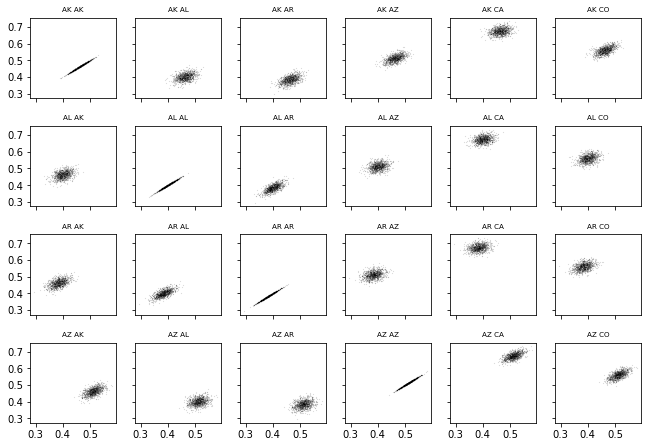

In [80]:
# Show correlation between distributions
mvn = np.random.multivariate_normal(mean=mu, cov=sigma, size=int(1e5))
pred = forecast.inv_logit(mvn)  # 0 to 1 
states = list(sim_forecast.columns)
rownum = 4
colnum = 6
fig, ax = plt.subplots(rownum, colnum, figsize=(colnum * 1.5, rownum * 1.5), sharey=True, sharex=True)
plt.rcParams.update({'font.size': 6, 'xtick.major.size': 6, 'ytick.major.size': 6})
plt.tight_layout(pad=0.5, h_pad=3)
for j in range(rownum):
    for i in range(colnum):
        x, y = pred[:, j][::100], pred[:, i][::100]
        ax[j][i].scatter(x=x, y=y, marker='.', s=0.01, color='black')
        ax[j][i].set_title(states[j] + ' ' + states[i])
        #ax[j][i].grid()
        #ax[i].set_xticks(np.arange(0, 1, 0.1))

In [78]:
SIM_BREAK_NUM = 10
def draw_samples(mu, sigma, names, biden_states=None, trump_states=None, 
                 biden_scores_list=None, target_nsim=1000):
    n = 0
    sim = None
    simnum = 0
    states = None
    upper_biden = None
    lower_biden = None
    
    if biden_scores_list is not None:
        states = biden_scores_list.columns.values
        lower_biden = biden_scores_list.iloc[0, :] / 100.0
        upper_biden = biden_scores_list.iloc[1, :] / 100.0 

    while simnum < target_nsim:
        # random sample from posterior distribution and reject based on constraints
        n += 1
        # make multivariate normal distribution w/ 100,000 samples
        mvn = np.random.multivariate_normal(mean=mu, cov=sigma, size=int(1e5))
        proposals = forecast.inv_logit(mvn)
        proposals = pd.DataFrame(data=proposals, columns=names)  # more efficient if index numbers
        if biden_states is not None:
            biden_idx = [proposals.columns.get_loc(n) for n in biden_states]
            rows, cols = np.where(proposals.iloc[:, biden_idx] < 0.5)
            proposals.iloc[rows, biden_idx] = np.nan
        if trump_states is not None:
            trump_idx = [proposals.columns.get_loc(n) for n in trump_states]
            rows, cols = np.where(proposals.iloc[:, trump_idx] > 0.5)
            proposals.iloc[rows, trump_idx] = np.nan
        if states is not None and upper_biden is not None and lower_biden is not None:
            for state in states:
                state_idx = [proposals.columns.get_loc(state)]
                rows1, cols1 = np.where(proposals.iloc[:, state_idx] > upper_biden[state]) 
                rows2, cols2 = np.where(proposals.iloc[:, state_idx] < lower_biden[state])
                rows = rows1.tolist() + rows2.tolist()
                proposals.iloc[rows, state_idx] = np.nan
        # reject nan
        proposals = proposals.dropna(axis=0)
        # Update sim
        if sim is None:
            sim = proposals.values
        else:
            sim = np.concatenate([sim, proposals.values], axis=0)
        if sim.shape[0] < target_nsim and sim.shape[0] / (proposals.shape[0] * n) < 0.0001:
            raise('numpy.random.multivariate_normal is working hard... but more than 99.99% of the '
                  'samples are rejected; you should relax some constraints.')
        if n == SIM_BREAK_NUM:
            break
        simnum = sim.shape[0]
    return sim

def update_prob(sim, ev):
    """Return Pr(biden wins) by state and Pr(biden wins the electoral college)."""
    ev_dist = np.matmul(sim > 0.5, ev.values[0])
    state_win = np.mean(sim > 0.5, axis=0)
    p = np.mean(ev_dist >= 270.0)
    sd = np.sqrt(p * (1 - p) / ev_dist.size)
    state_df = pd.DataFrame({k : [d] for k, d in zip(ev.columns, np.round(100 * state_win, 1))})
    print('Pr(biden wins the electoral college) = {}'.format(np.round(100 * p, 1)) +
          '\nnsim = {}; se = {}%'.format(ev_dist.size, np.round(sd * 100, 1)))
    return state_df

In [79]:
biden_states, trump_states = ['VA'], ['FL']
biden_scores_list = pd.DataFrame({'MI':[45, 55], 'NV':[46, 56]})
names = sim_forecast.columns.values

# draw samples
sim = draw_samples(mu, sigma, names, biden_states, trump_states, biden_scores_list, target_nsim=1000)
update_prob(sim, ev)

Pr(biden wins the electoral college) = 83.3
nsim = 18806; se = 0.3%


,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1.1,0.0,0.0,36.9,100.0,99.6,100.0,100.0,100.0,0.0,34.4,100.0,13.2,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,99.8,93.3,96.4,0.0,0.0,0.0,38.9,0.0,0.0,94.7,100.0,99.2,80.7,100.0,7.4,0.0,100.0,78.3,100.0,0.0,0.0,0.0,14.2,0.0,100.0,100.0,100.0,92.0,0.0,0.0
